In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 3.3.1
Uninstalling lightgbm-3.3.1:
  Successfully uninstalled lightgbm-3.3.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached lightgbm-3.3.1-py3-none-manylinux1_x86_64.whl (2.0 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'categories']
    vec_columns = ['name', 'categories', 'address', 
                  'state']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country

    train_df['kdist_diff'] = (train_df['kdist'] - train_df['kdist_country']) /\
                    train_df['kdist_country']
    train_df['kneighbors_mean'] = train_df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return train_df

In [ ]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        vc = data[col].value_counts()
        geshs = []
        levens = []
        jaros = []
        lcss = []
        vc1 = []
        vc2 = []

        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan':
                vc1.append(vc[s])
            else:
                vc1.append(np.nan)

            if match_s != 'nan':
                vc2.append(vc[match_s])
            else:
                vc2.append(np.nan)

            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        df[f'{col}_CE_1'] = vc1
        df[f'{col}_CE_2'] = vc2
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=2, seed=CFG.SEED)):
    data.loc[val_ind, "set"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - set {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - set {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 0,37.32%,48.77%,6.38%,2.08%,5.44%
validation set - set 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - set 1,37.32%,48.77%,6.38%,2.08%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

train_data = data.loc[data['set'] == 0]
test_data = data.loc[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
0.0    569408
1.0    569404
Name: set, dtype: int64
Train data: 
Num of data: 569408
Num of unique id: 569408
Num of unique poi: 369986
Mean num of unique poi: 1.538998772926543
Test data: 
Num of data: 569404
Num of unique id: 569404
Num of unique poi: 369986
Mean num of unique poi: 1.538987961706659
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data[col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['set'] == 0], CFG.num_neighbors)
test_data = recall_knn(data.loc[data['set'] == 1], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/206 [00:00<?, ?it/s]

Start knn
Start knn grouped by country


  0%|          | 0/209 [00:00<?, ?it/s]

Start knn
Num of unique id: 569408
Num of train data: 13916774
Pos rate: 0.07237136997410464
                       id          match_id     kdist  kneighbors  \
9669022  E_fb2423f3ecb535  E_ef0bc5de79e10b  0.002962        16.0   
4179479  E_5711e77f4f6716  E_88601b987e6f2c  0.013405         7.0   
2843346  E_fe5b07e0a8a9c5  E_0cffaaebc584d9  0.006918         4.0   
5672212  E_f624aa54796b00  E_b227f88db2fe18  0.003901         9.0   
1412325  E_7b07bee29838a7  E_8d81634e3378a0  0.001450         2.0   

        point_of_interest  kdist_country  kneighbors_country  kdist_diff  \
9669022  P_7aeff722d67fa9       0.001594                 8.0    0.858537   
4179479  P_728ab357db351e       0.013241                 7.0    0.012328   
2843346  P_5f256e9da11ffe       0.004618                 6.0    0.498116   
5672212  P_1ef23c0ca7dfdf       0.002758                 7.0    0.414395   
1412325  P_4507ac6a9d85a4       0.000710                 2.0    1.043830   

         kneighbors_mean  label  
9

In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9226548761979743


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.76%,7.24%
development set - fold 0,92.76%,7.24%
validation set - fold 0,92.76%,7.24%
development set - fold 1,92.76%,7.24%
validation set - fold 1,92.76%,7.24%
development set - fold 2,92.76%,7.24%
validation set - fold 2,92.76%,7.24%
development set - fold 3,92.76%,7.24%
validation set - fold 3,92.76%,7.24%
development set - fold 4,92.76%,7.24%


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

for c in CFG.feat_columns:
    features += [c + "_CE_1", c + "_CE_2"]

print(len(features))
print(features)

66
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'categories_nleven', 'categories_nlcsk', 'categories_nlcs', 'categories_sim', 'name_CE_1', 'name_CE_2', 'address_CE_1', 'address_CE_2', 'city_CE_1', 'city_CE_2', 'state_CE_1', 'state_CE_2', 'zip_CE_1', 'zip_CE_2', 'categories_CE_1', 'cate

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0424595
[100]	valid_0's binary_logloss: 0.0399154
[150]	valid_0's binary_logloss: 0.0387462
[200]	valid_0's binary_logloss: 0.0380636
[250]	valid_0's binary_logloss: 0.0375058
[300]	valid_0's binary_logloss: 0.0370078
[350]	valid_0's binary_logloss: 0.0366265
[400]	valid_0's binary_logloss: 0.0362786
[450]	valid_0's binary_logloss: 0.0360017
[500]	valid_0's binary_logloss: 0.0357405
[550]	valid_0's binary_logloss: 0.035526
[600]	valid_0's binary_logloss: 0.0352918
[650]	valid_0's binary_logloss: 0.0350724
[700]	valid_0's binary_logloss: 0.0349104
[750]	valid_0's binary_logloss: 0.0347023
[800]	valid_0's binary_logloss: 0.0345284
[850]	valid_0's binary_logloss: 0.0343681
[900]	valid_0's binary_logloss: 0.0341665
[950]	valid_0's binary_logloss: 0.0340094
[1000]	valid_0's binary_logloss: 0.0338559
[1050]	valid_0's binary_logloss: 0.0337159
[1100]	valid_0's binary_logloss: 0.0335897
[1150]	valid_0's binary_logloss: 0.0334623
[1200]	valid_0's binary_logloss:

In [ ]:
del train_data
gc.collect()

85

#Check Feature Importances

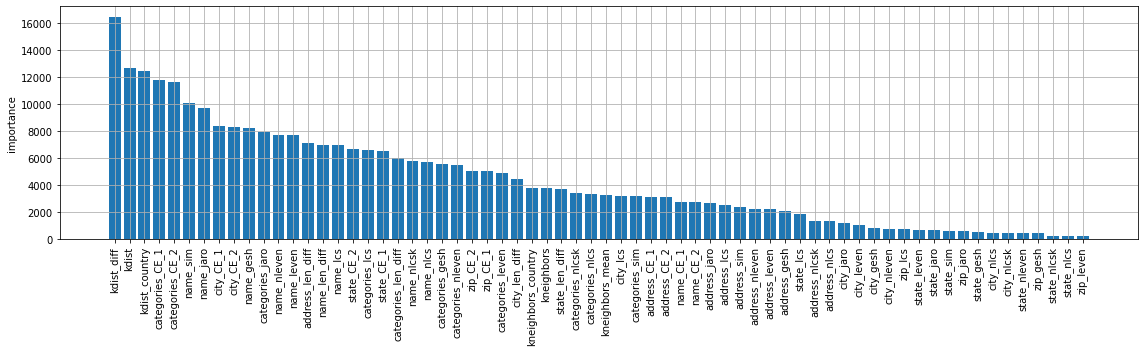

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-26 20:13:32,190] A new study created in memory with name: no-name-c6fbd2a2-7c55-4fcb-ba25-173b23f0b5b8
[I 2022-05-26 20:14:40,773] Trial 0 finished with value: 0.8266876994962757 and parameters: {'threshold': 0.8732433699751629}. Best is trial 0 with value: 0.8266876994962757.


CV: 0.826688


[I 2022-05-26 20:15:01,158] Trial 1 finished with value: 0.8422765121229925 and parameters: {'threshold': 0.5624091930666603}. Best is trial 1 with value: 0.8422765121229925.


CV: 0.842277


[I 2022-05-26 20:15:23,277] Trial 2 finished with value: 0.8168322345361486 and parameters: {'threshold': 0.17218699475843968}. Best is trial 1 with value: 0.8422765121229925.


CV: 0.816832


[I 2022-05-26 20:15:43,605] Trial 3 finished with value: 0.8404258192035776 and parameters: {'threshold': 0.4363720365262538}. Best is trial 1 with value: 0.8422765121229925.


CV: 0.840426


[I 2022-05-26 20:16:04,869] Trial 4 finished with value: 0.8416813246635751 and parameters: {'threshold': 0.4960458352103734}. Best is trial 1 with value: 0.8422765121229925.


CV: 0.841681


[I 2022-05-26 20:16:27,892] Trial 5 finished with value: 0.7628003526325284 and parameters: {'threshold': 0.05078944365027527}. Best is trial 1 with value: 0.8422765121229925.


CV: 0.762800


[I 2022-05-26 20:16:49,648] Trial 6 finished with value: 0.8273962524854275 and parameters: {'threshold': 0.24131318938659507}. Best is trial 1 with value: 0.8422765121229925.


CV: 0.827396


[I 2022-05-26 20:17:11,706] Trial 7 finished with value: 0.8044420370713102 and parameters: {'threshold': 0.12300438700611505}. Best is trial 1 with value: 0.8422765121229925.


CV: 0.804442


[I 2022-05-26 20:17:32,527] Trial 8 finished with value: 0.8392810270766943 and parameters: {'threshold': 0.7282220064932918}. Best is trial 1 with value: 0.8422765121229925.


CV: 0.839281


[I 2022-05-26 20:17:53,055] Trial 9 finished with value: 0.8309117497581493 and parameters: {'threshold': 0.8409392705377713}. Best is trial 1 with value: 0.8422765121229925.


CV: 0.830912


[I 2022-05-26 20:18:16,392] Trial 10 finished with value: 0.8401843939351207 and parameters: {'threshold': 0.7060163920836653}. Best is trial 1 with value: 0.8422765121229925.


CV: 0.840184


[I 2022-05-26 20:18:37,775] Trial 11 finished with value: 0.8412750629353843 and parameters: {'threshold': 0.4756151349830823}. Best is trial 1 with value: 0.8422765121229925.


CV: 0.841275


[I 2022-05-26 20:18:57,685] Trial 12 finished with value: 0.8422176212794962 and parameters: {'threshold': 0.5986864795287639}. Best is trial 1 with value: 0.8422765121229925.


CV: 0.842218


[I 2022-05-26 20:19:18,428] Trial 13 finished with value: 0.8416521179774384 and parameters: {'threshold': 0.6509667679683969}. Best is trial 1 with value: 0.8422765121229925.


CV: 0.841652


[I 2022-05-26 20:19:39,798] Trial 14 finished with value: 0.8373782801297979 and parameters: {'threshold': 0.3640922365337407}. Best is trial 1 with value: 0.8422765121229925.


CV: 0.837378


[I 2022-05-26 20:19:59,727] Trial 15 finished with value: 0.8421629134041071 and parameters: {'threshold': 0.6070796168111356}. Best is trial 1 with value: 0.8422765121229925.


CV: 0.842163


[I 2022-05-26 20:20:19,713] Trial 16 finished with value: 0.7410508970795495 and parameters: {'threshold': 0.9949016958125294}. Best is trial 1 with value: 0.8422765121229925.


CV: 0.741051


[I 2022-05-26 20:20:41,250] Trial 17 finished with value: 0.8363980136686353 and parameters: {'threshold': 0.3467391133505571}. Best is trial 1 with value: 0.8422765121229925.


CV: 0.836398


[I 2022-05-26 20:21:01,315] Trial 18 finished with value: 0.8422783097007916 and parameters: {'threshold': 0.5716935012432837}. Best is trial 18 with value: 0.8422783097007916.


CV: 0.842278


[I 2022-05-26 20:21:22,719] Trial 19 finished with value: 0.8337075371428129 and parameters: {'threshold': 0.307861461499077}. Best is trial 18 with value: 0.8422783097007916.


CV: 0.833708


[I 2022-05-26 20:21:42,763] Trial 20 finished with value: 0.8422763090295594 and parameters: {'threshold': 0.5575052014898215}. Best is trial 18 with value: 0.8422783097007916.


CV: 0.842276


[I 2022-05-26 20:22:03,737] Trial 21 finished with value: 0.8422726590223977 and parameters: {'threshold': 0.5625467191463558}. Best is trial 18 with value: 0.8422783097007916.


CV: 0.842273


[I 2022-05-26 20:22:25,763] Trial 22 finished with value: 0.8356861810744884 and parameters: {'threshold': 0.7900541314195993}. Best is trial 18 with value: 0.8422783097007916.


CV: 0.835686


[I 2022-05-26 20:22:45,783] Trial 23 finished with value: 0.8422237985092289 and parameters: {'threshold': 0.5448067511693373}. Best is trial 18 with value: 0.8422783097007916.


CV: 0.842224


[I 2022-05-26 20:23:06,914] Trial 24 finished with value: 0.8395019128697702 and parameters: {'threshold': 0.40891908658862675}. Best is trial 18 with value: 0.8422783097007916.


CV: 0.839502


[I 2022-05-26 20:23:27,575] Trial 25 finished with value: 0.8408850473848986 and parameters: {'threshold': 0.6841052247131076}. Best is trial 18 with value: 0.8422783097007916.


CV: 0.840885


[I 2022-05-26 20:23:47,642] Trial 26 finished with value: 0.8422324472532549 and parameters: {'threshold': 0.5453598960676442}. Best is trial 18 with value: 0.8422783097007916.


CV: 0.842232


[I 2022-05-26 20:24:08,191] Trial 27 finished with value: 0.8361806966024834 and parameters: {'threshold': 0.7825817507692934}. Best is trial 18 with value: 0.8422783097007916.


CV: 0.836181
CV: 0.841850


[I 2022-05-26 20:24:33,040] Trial 28 finished with value: 0.8418499517478968 and parameters: {'threshold': 0.6387667618321627}. Best is trial 18 with value: 0.8422783097007916.
[I 2022-05-26 20:25:00,759] Trial 29 finished with value: 0.7960201684596182 and parameters: {'threshold': 0.9639356293684632}. Best is trial 18 with value: 0.8422783097007916.


CV: 0.796020


[I 2022-05-26 20:25:22,262] Trial 30 finished with value: 0.840632514661913 and parameters: {'threshold': 0.4425446146534914}. Best is trial 18 with value: 0.8422783097007916.


CV: 0.840633


[I 2022-05-26 20:25:42,448] Trial 31 finished with value: 0.8422107384514554 and parameters: {'threshold': 0.5396753461411278}. Best is trial 18 with value: 0.8422783097007916.


CV: 0.842211


[I 2022-05-26 20:26:03,551] Trial 32 finished with value: 0.8422923410771233 and parameters: {'threshold': 0.5765424595734046}. Best is trial 32 with value: 0.8422923410771233.


CV: 0.842292


[I 2022-05-26 20:26:25,507] Trial 33 finished with value: 0.8414719606760892 and parameters: {'threshold': 0.4866072773947179}. Best is trial 32 with value: 0.8422923410771233.


CV: 0.841472


[I 2022-05-26 20:26:45,304] Trial 34 finished with value: 0.838360879799331 and parameters: {'threshold': 0.7452846478396441}. Best is trial 32 with value: 0.8422923410771233.


CV: 0.838361


[I 2022-05-26 20:27:06,330] Trial 35 finished with value: 0.8421806810230965 and parameters: {'threshold': 0.6025852207412352}. Best is trial 32 with value: 0.8422923410771233.


CV: 0.842181


[I 2022-05-26 20:27:27,804] Trial 36 finished with value: 0.8387508569167882 and parameters: {'threshold': 0.3923889286310606}. Best is trial 32 with value: 0.8422923410771233.


CV: 0.838751


[I 2022-05-26 20:27:48,429] Trial 37 finished with value: 0.8299388177020454 and parameters: {'threshold': 0.263729789707863}. Best is trial 32 with value: 0.8422923410771233.


CV: 0.829939


[I 2022-05-26 20:28:09,625] Trial 38 finished with value: 0.8414598692842301 and parameters: {'threshold': 0.48613905351408904}. Best is trial 32 with value: 0.8422923410771233.


CV: 0.841460


[I 2022-05-26 20:28:28,986] Trial 39 finished with value: 0.8214370773612132 and parameters: {'threshold': 0.9011085019119329}. Best is trial 32 with value: 0.8422923410771233.


CV: 0.821437


[I 2022-05-26 20:28:49,834] Trial 40 finished with value: 0.8413998608247059 and parameters: {'threshold': 0.660850472474122}. Best is trial 32 with value: 0.8422923410771233.


CV: 0.841400


[I 2022-05-26 20:29:10,901] Trial 41 finished with value: 0.8422996982344592 and parameters: {'threshold': 0.5561186582258764}. Best is trial 41 with value: 0.8422996982344592.


CV: 0.842300


[I 2022-05-26 20:29:30,904] Trial 42 finished with value: 0.8421255618221123 and parameters: {'threshold': 0.5234285284637155}. Best is trial 41 with value: 0.8422996982344592.


CV: 0.842126


[I 2022-05-26 20:29:51,913] Trial 43 finished with value: 0.8422595578970784 and parameters: {'threshold': 0.5901820251693167}. Best is trial 41 with value: 0.8422996982344592.


CV: 0.842260


[I 2022-05-26 20:30:13,189] Trial 44 finished with value: 0.8410076946674175 and parameters: {'threshold': 0.46338881790956166}. Best is trial 41 with value: 0.8422996982344592.


CV: 0.841008


[I 2022-05-26 20:30:34,713] Trial 45 finished with value: 0.8402919036914658 and parameters: {'threshold': 0.7025686692444618}. Best is trial 41 with value: 0.8422996982344592.


CV: 0.840292


[I 2022-05-26 20:30:58,662] Trial 46 finished with value: 0.7205218039032912 and parameters: {'threshold': 0.025059188977027913}. Best is trial 41 with value: 0.8422996982344592.


CV: 0.720522


[I 2022-05-26 20:31:18,533] Trial 47 finished with value: 0.8417603044503901 and parameters: {'threshold': 0.6439184080471184}. Best is trial 41 with value: 0.8422996982344592.


CV: 0.841760


[I 2022-05-26 20:31:39,416] Trial 48 finished with value: 0.8419733980692876 and parameters: {'threshold': 0.513381698002643}. Best is trial 41 with value: 0.8422996982344592.


CV: 0.841973


[I 2022-05-26 20:32:01,452] Trial 49 finished with value: 0.8094216959806317 and parameters: {'threshold': 0.14018286204611885}. Best is trial 41 with value: 0.8422996982344592.


CV: 0.809422


[I 2022-05-26 20:32:21,648] Trial 50 finished with value: 0.8422207747026389 and parameters: {'threshold': 0.5839500236799706}. Best is trial 41 with value: 0.8422996982344592.


CV: 0.842221


[I 2022-05-26 20:32:42,670] Trial 51 finished with value: 0.8422631024807121 and parameters: {'threshold': 0.5606230349699313}. Best is trial 41 with value: 0.8422996982344592.


CV: 0.842263


[I 2022-05-26 20:33:03,988] Trial 52 finished with value: 0.8399889900865302 and parameters: {'threshold': 0.42365074208567544}. Best is trial 41 with value: 0.8422996982344592.


CV: 0.839989


[I 2022-05-26 20:33:25,119] Trial 53 finished with value: 0.8419220676397546 and parameters: {'threshold': 0.6352399879652096}. Best is trial 41 with value: 0.8422996982344592.


CV: 0.841922


[I 2022-05-26 20:33:45,231] Trial 54 finished with value: 0.8422600936263452 and parameters: {'threshold': 0.5707225808254383}. Best is trial 41 with value: 0.8422996982344592.


CV: 0.842260


[I 2022-05-26 20:34:06,150] Trial 55 finished with value: 0.8392180120448091 and parameters: {'threshold': 0.7295039251484023}. Best is trial 41 with value: 0.8422996982344592.


CV: 0.839218


[I 2022-05-26 20:34:26,342] Trial 56 finished with value: 0.8418260767557064 and parameters: {'threshold': 0.5031408222118742}. Best is trial 41 with value: 0.8422996982344592.


CV: 0.841826


[I 2022-05-26 20:34:48,807] Trial 57 finished with value: 0.842168158503941 and parameters: {'threshold': 0.6113305766033915}. Best is trial 41 with value: 0.8422996982344592.


CV: 0.842168


[I 2022-05-26 20:35:09,670] Trial 58 finished with value: 0.8409623019467128 and parameters: {'threshold': 0.6800521524002361}. Best is trial 41 with value: 0.8422996982344592.


CV: 0.840962


[I 2022-05-26 20:35:29,782] Trial 59 finished with value: 0.8408727648026113 and parameters: {'threshold': 0.4558818054321729}. Best is trial 41 with value: 0.8422996982344592.


CV: 0.840873


[I 2022-05-26 20:35:51,116] Trial 60 finished with value: 0.8383060967103876 and parameters: {'threshold': 0.3824584225816423}. Best is trial 41 with value: 0.8422996982344592.


CV: 0.838306


[I 2022-05-26 20:36:12,095] Trial 61 finished with value: 0.8422331371423505 and parameters: {'threshold': 0.5438740184029394}. Best is trial 41 with value: 0.8422996982344592.


CV: 0.842233


[I 2022-05-26 20:36:33,178] Trial 62 finished with value: 0.8422836042897546 and parameters: {'threshold': 0.5656951783438936}. Best is trial 41 with value: 0.8422996982344592.


CV: 0.842284


[I 2022-05-26 20:36:54,140] Trial 63 finished with value: 0.8419755133605076 and parameters: {'threshold': 0.6280291623557248}. Best is trial 41 with value: 0.8422996982344592.


CV: 0.841976


[I 2022-05-26 20:37:14,070] Trial 64 finished with value: 0.8422727090239706 and parameters: {'threshold': 0.5643273436546276}. Best is trial 41 with value: 0.8422996982344592.


CV: 0.842273


[I 2022-05-26 20:37:35,159] Trial 65 finished with value: 0.8418995144000263 and parameters: {'threshold': 0.5076310948887814}. Best is trial 41 with value: 0.8422996982344592.


CV: 0.841900


[I 2022-05-26 20:37:56,310] Trial 66 finished with value: 0.8423135140184341 and parameters: {'threshold': 0.5745580270785102}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.842314


[I 2022-05-26 20:38:16,745] Trial 67 finished with value: 0.8363289051462247 and parameters: {'threshold': 0.34559784347376254}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.836329


[I 2022-05-26 20:38:39,741] Trial 68 finished with value: 0.8374148148928229 and parameters: {'threshold': 0.7637045947281887}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.837415


[I 2022-05-26 20:38:59,603] Trial 69 finished with value: 0.8410258156904922 and parameters: {'threshold': 0.6764587378939737}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.841026


[I 2022-05-26 20:39:20,412] Trial 70 finished with value: 0.84217368910951 and parameters: {'threshold': 0.6047627405780498}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.842174


[I 2022-05-26 20:39:41,331] Trial 71 finished with value: 0.8422493719434901 and parameters: {'threshold': 0.5590726639035626}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.842249


[I 2022-05-26 20:40:01,346] Trial 72 finished with value: 0.8421223677008324 and parameters: {'threshold': 0.5225728637316835}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.842122


[I 2022-05-26 20:40:22,394] Trial 73 finished with value: 0.8422430205907634 and parameters: {'threshold': 0.582050194423365}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.842243


[I 2022-05-26 20:40:43,094] Trial 74 finished with value: 0.8420040765099323 and parameters: {'threshold': 0.6272566194533665}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.842004


[I 2022-05-26 20:41:04,102] Trial 75 finished with value: 0.8412995608370772 and parameters: {'threshold': 0.4772227516737344}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.841300


[I 2022-05-26 20:41:25,297] Trial 76 finished with value: 0.8402588213659677 and parameters: {'threshold': 0.43119371569890275}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.840259


[I 2022-05-26 20:41:45,047] Trial 77 finished with value: 0.840064610271831 and parameters: {'threshold': 0.7087672459090764}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.840065


[I 2022-05-26 20:42:05,869] Trial 78 finished with value: 0.8421917882970122 and parameters: {'threshold': 0.5344697689131032}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.842192


[I 2022-05-26 20:42:26,785] Trial 79 finished with value: 0.841358287831101 and parameters: {'threshold': 0.6639036113565031}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.841358


[I 2022-05-26 20:42:46,827] Trial 80 finished with value: 0.8415396544018607 and parameters: {'threshold': 0.48914101941443}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.841540


[I 2022-05-26 20:43:08,159] Trial 81 finished with value: 0.8422360517957808 and parameters: {'threshold': 0.5804080700232199}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.842236


[I 2022-05-26 20:43:29,234] Trial 82 finished with value: 0.8422780860371966 and parameters: {'threshold': 0.5532791267641426}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.842278


[I 2022-05-26 20:43:49,105] Trial 83 finished with value: 0.8422759343789253 and parameters: {'threshold': 0.5490878856557719}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.842276


[I 2022-05-26 20:44:09,709] Trial 84 finished with value: 0.8421556530390114 and parameters: {'threshold': 0.6197732940677205}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.842156


[I 2022-05-26 20:44:30,588] Trial 85 finished with value: 0.8421347003416081 and parameters: {'threshold': 0.5263922993317016}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.842135


[I 2022-05-26 20:44:50,662] Trial 86 finished with value: 0.8408254033720456 and parameters: {'threshold': 0.4533037396948743}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.840825


[I 2022-05-26 20:45:11,405] Trial 87 finished with value: 0.8421970754720217 and parameters: {'threshold': 0.6009191811795422}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.842197


[I 2022-05-26 20:45:32,261] Trial 88 finished with value: 0.8422412979965282 and parameters: {'threshold': 0.5461388878147897}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.842241


[I 2022-05-26 20:45:53,314] Trial 89 finished with value: 0.8419799215793151 and parameters: {'threshold': 0.513827812991786}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.841980


[I 2022-05-26 20:46:14,412] Trial 90 finished with value: 0.8413104305138724 and parameters: {'threshold': 0.4776042636833989}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.841310


[I 2022-05-26 20:46:34,362] Trial 91 finished with value: 0.842272940911937 and parameters: {'threshold': 0.562525149268934}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.842273


[I 2022-05-26 20:46:55,633] Trial 92 finished with value: 0.842248962350886 and parameters: {'threshold': 0.5880714438785878}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.842249


[I 2022-05-26 20:47:16,418] Trial 93 finished with value: 0.8417075826184246 and parameters: {'threshold': 0.6481821004905772}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.841708


[I 2022-05-26 20:47:36,363] Trial 94 finished with value: 0.8422861899280363 and parameters: {'threshold': 0.5667618952296608}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.842286


[I 2022-05-26 20:47:57,155] Trial 95 finished with value: 0.8422454340987411 and parameters: {'threshold': 0.547015294914001}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.842245


[I 2022-05-26 20:48:18,067] Trial 96 finished with value: 0.8416758002892339 and parameters: {'threshold': 0.494780685574265}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.841676


[I 2022-05-26 20:48:39,105] Trial 97 finished with value: 0.8422120794753686 and parameters: {'threshold': 0.595890840484631}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.842212


[I 2022-05-26 20:48:58,957] Trial 98 finished with value: 0.8421568677930309 and parameters: {'threshold': 0.6174788274166396}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.842157


[I 2022-05-26 20:49:19,785] Trial 99 finished with value: 0.8404294178537259 and parameters: {'threshold': 0.6985170641272486}. Best is trial 66 with value: 0.8423135140184341.


CV: 0.840429


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5745580270785102

In [ ]:
study.best_value

0.8423135140184341

In [ ]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.842314


# 間違っているものの中身を見る

In [ ]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [ ]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,128291.000000,128291.000000,124309.000000,124309.000000,118915.000000,132339.000000,132339.0,132339.000000,132339.000000,132339.000000,...,97959.000000,97959.000000,97959.000000,111980.000000,112126.000000,132339.000000,97959.000000,97959.000000,97959.000000,1.323390e+05
mean,0.006955,6.336742,0.003547,6.365669,0.426703,6.639388,1.0,0.265383,0.408955,16.703391,...,12.552711,0.675330,9.135792,5607.124406,5604.377789,9.194463,0.536104,0.582700,0.583340,1.905931e-01
std,0.059435,5.265374,0.024269,5.271836,2.439070,5.323184,0.0,0.296730,0.247213,9.461624,...,11.688794,0.243816,7.360119,6759.741890,6753.561185,11.080454,0.353786,0.330739,0.330236,1.795347e-01
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.437365e-10
25%,0.000453,2.000000,0.000339,2.000000,0.005695,2.000000,1.0,0.000000,0.210526,10.000000,...,0.000000,0.483333,4.000000,757.000000,757.000000,0.000000,0.000000,0.285714,0.285714,2.560788e-02
50%,0.001142,5.000000,0.000880,5.000000,0.057228,5.000000,1.0,0.176762,0.392157,16.000000,...,12.000000,0.584046,7.000000,2892.000000,2892.000000,6.000000,0.714286,0.500000,0.500000,1.328938e-01
75%,0.003109,10.000000,0.002391,10.000000,0.319807,10.500000,1.0,0.489843,0.585366,22.000000,...,17.000000,1.000000,12.000000,7208.000000,7208.000000,13.000000,0.823529,1.000000,1.000000,3.355464e-01
max,4.448372,19.000000,2.388985,19.000000,214.206825,19.000000,1.0,1.000000,1.000000,59.000000,...,87.000000,1.000000,77.000000,25481.000000,25481.000000,90.000000,1.000000,1.000000,1.000000,5.745477e-01


In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
5950388,E_731f2153e7cc93,E_77a708a7fc8d14,0.002144,10.0,P_f2df149bcb3843,0.002136,11.0,0.003928,10.5,1,...,0.0,1.000000,11.0,1950.0,1950.0,0,0.000000,1.000000,1.000000,0.136364
2402512,E_38018137183f24,E_3b0adee4aabf32,0.001750,4.0,P_4e6f4a6f0462f1,0.001705,4.0,0.026299,4.0,1,...,11.0,0.629630,5.0,11981.0,288.0,6,0.733333,0.333333,0.555556,0.223826
5221782,E_2b822b4ea526a1,E_4355f363ac6b88,0.002772,9.0,P_6b4e9ce8cc9832,0.002772,9.0,0.000010,9.0,1,...,9.0,0.479853,4.0,314.0,562.0,6,0.692308,0.307692,0.571429,0.459232
2196431,E_db5454074bc3da,E_7cf488a583843f,0.000752,3.0,P_4afd41ad035bed,0.000717,3.0,0.048338,3.0,1,...,33.0,0.463492,2.0,2854.0,4.0,29,0.942857,0.057143,0.333333,0.008569
5029733,E_d5199aee5aa46c,E_9679c60f735f55,0.000166,8.0,P_f82d146eaf21da,0.000100,8.0,0.654282,8.0,1,...,16.0,0.528042,6.0,1345.0,633.0,6,0.761905,0.285714,0.400000,0.388906
2342630,E_1d227f90afa810,E_0a1d248bf36c19,0.001845,4.0,P_2c64deeed33af4,0.001030,3.0,0.792368,3.5,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0.125138
1254926,E_34074917842133,E_794c8a60ff3de3,0.014963,2.0,P_1ba2e3ee3ac506,0.014576,2.0,0.026556,2.0,1,...,15.0,0.467787,2.0,6411.0,1225.0,10,0.882353,0.117647,0.285714,0.100747
670235,E_2d2bcb1c140429,E_4fe3e356df366a,0.000409,1.0,P_709fd4a3162388,0.000322,1.0,0.271061,1.0,1,...,NaN,NaN,NaN,9676.0,NaN,6,NaN,NaN,NaN,0.134253
9983969,E_88822fe5707656,E_6ec6ce64b4b1c1,0.005790,17.0,NaN,NaN,NaN,NaN,17.0,1,...,NaN,NaN,NaN,21494.0,NaN,2,NaN,NaN,NaN,0.208484
4252813,E_77ebe3319c17c0,E_f0f7e9b7e572fc,0.002790,7.0,P_0f3b602980b42d,0.002759,7.0,0.011172,7.0,1,...,9.0,0.448413,3.0,2125.0,1232.0,5,0.750000,0.250000,0.428571,0.112517


In [ ]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
854537,E_bfeb40aeda54bf,Oda,38.767952,41.491550,Bağlar Mahallesi,NaN,NaN,NaN,TR,NaN,NaN,Buildings,P_eda9e738ade971,4,1.0
969490,E_d9c661e6b6889f,35. Mühimmat Bölük Komutanlığı,38.766250,41.472217,Kızılağaç 7. Km.,Muş,NaN,49100,TR,NaN,04362160292,"Military Bases, Butchers, Coworking Spaces",P_eda9e738ade971,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
633634,E_8e76386600bbaf,Copenhagen Airport,55.629159,12.637024,NaN,Kastrup,Danmark,2770,DK,NaN,NaN,Airports,P_de322dff6e3a8b,4,1.0
831303,E_baae9beb63e6dd,Københavns Lufthavn (CPH),55.627230,12.649947,Lufthavnsboulevarden 6,Kastrup,Hovedstaden,2770,DK,https://www.cph.dk,32313231,Airports,P_de322dff6e3a8b,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
775822,E_ae4268d1ccdb8a,Biga Pakt Plus AVM,40.226480,27.242887,Eski Garaj Yanı,NaN,NaN,NaN,TR,NaN,NaN,Shopping Malls,P_e327405bf2c103,3,1.0
1037718,E_e925a49f89c0b2,Avm Arkasıı,40.226092,27.249880,Şehit Yarbay Necdet Hoşgör Caddesi,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_e327405bf2c103,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
89801,E_1420578b02a0cb,Mesjid taman makam pahlawan,5.544353,95.323932,Kp. Ateuk Pahlawan,Banda Aceh,Indonesia,NaN,ID,NaN,NaN,NaN,P_bd03887ba9f953,2,1.0
411368,E_5c71881066adcf,Masjid Besar Pahlawan,5.546397,95.323471,"Jl. Taman Makam Pahlawan, Kp. Ateuk",Banda Aceh,Aceh,NaN,ID,NaN,NaN,Mosques,P_bd03887ba9f953,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
950742,E_d59109670c87b6,olukkoyağı mekaan,37.232027,34.689954,NaN,NaN,NaN,NaN,TR,NaN,NaN,Rivers,P_2f497b9a2a7a5e,3,1.0
1035696,E_e8b2c221780bf6,Olukkayagi Koyu,37.230364,34.676873,Tarsus,Mersin,NaN,NaN,TR,NaN,NaN,Other Great Outdoors,P_2f497b9a2a7a5e,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
67908,E_0f3180b843d8cc,airport two,39.613909,-75.931465,NaN,NaN,MD,NaN,US,NaN,NaN,Airports,P_5ed87830d1bce9,4,1.0
1066453,E_efae70898ee02c,airport 29,39.613625,-75.931846,NaN,NaN,MD,NaN,US,NaN,NaN,Airports,P_5ed87830d1bce9,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
814069,E_b6d11ef5fa7088,Trans 7 5th floor (PT. Televisi Transformasi I...,-6.241248,106.830043,NaN,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,NaN,P_745299120115a1,4,1.0
932296,E_d16b86161ea298,Meja Receptionist Lantai 9,-6.241242,106.830042,Jl. Kapt tendean 12-14a,Jakarta Capital Region,Jakarta Capital Region,12710,ID,NaN,NaN,Buildings,P_745299120115a1,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
603770,E_87b364c6e5b63c,Хипстерская беседка,55.806398,37.474175,NaN,NaN,NaN,NaN,RU,NaN,NaN,Parks,P_9d83fd18d69440,4,1.0
1028177,E_e701c68b6029c5,Щукинский парк,55.805830,37.469176,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_9d83fd18d69440,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
735254,E_a52c080592d9c4,Eskişehir Acıbadem Hastanesi Yenidoğan Yoğun B...,39.784935,30.495083,NaN,NaN,NaN,NaN,TR,NaN,NaN,Medical Centers,P_3d04642c63888e,4,1.0
1018825,E_e4e622197d70af,acıbadem hastanesi doğumhane,39.785008,30.495890,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_3d04642c63888e,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
501728,E_70cfd07d44ede1,Cosmetic Susan Meier,47.055069,8.309703,NaN,Luzern,NaN,NaN,CH,NaN,NaN,"Health & Beauty Services, Nail Salons, Massage...",P_a191ccd6a1bd3c,1,1.0
727907,E_a382d2268b9063,Sēidu,47.055067,8.309838,Hertensteinstrasse 22,Luzern,LU,6004,CH,http://seidu-kosmetik.ch,+41414108822,Health & Beauty Services,P_a191ccd6a1bd3c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
207610,E_2e95ad72fa091a,My Gym,22.271458,114.148888,The Peak,Hong Kong,NaN,NaN,HK,NaN,NaN,NaN,P_f0bc511fab1637,4,1.0
937355,E_d28d337772ed9c,The Peak Hong Kong,22.271068,114.149892,NaN,NaN,NaN,NaN,HK,NaN,NaN,NaN,P_f0bc511fab1637,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
390942,E_57d4bc07b90db8,baffalo's avenu.,29.302343,47.930447,NaN,NaN,NaN,NaN,KW,NaN,NaN,American Restaurants,P_b7860ec637fa32,4,1.0
1055680,E_ed3abba806aff3,بافلوز كافيه,29.302204,47.930703,الافنيوز,NaN,NaN,NaN,KW,NaN,NaN,American Restaurants,P_b7860ec637fa32,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
186124,E_29c244f203c8db,сош 556,60.089487,29.95122,Токарева 20,NaN,NaN,NaN,RU,NaN,NaN,"College Classrooms, High Schools, Athletics & ...",P_4455402e0d492c,4,1.0
1021576,E_e586b519fb7d73,алгебра💩,60.089357,29.94913,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_4455402e0d492c,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
871118,E_c3ad8d6a5d650d,Omicron Sigma,32.880790,-117.235162,NaN,La Jolla,CA,92093,US,NaN,NaN,College Auditoriums,P_6c819b6cd468cc,1,1.0
885661,E_c6ebc541bdbb6a,ΔΣΠ | OMICRON SIGMA - Meet the Chapter,32.879677,-117.236309,9500 Gilman Dr,La Jolla,CA,92093,US,NaN,NaN,Other Events,P_6c819b6cd468cc,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
703637,E_9e0926df99c8ec,secretaria de relaciones exteriores,19.449946,-99.138440,ricardo flores magon,Cuauhtémoc,DF,NaN,MX,NaN,NaN,NaN,P_7986ec00d46630,1,1.0
740340,E_a65168666a8153,Secretaría de Relaciones Exteriores,19.449256,-99.137256,Av. Ricardo Flores Magón 2,Cuauhtémoc,DF,06995,MX,NaN,NaN,"Government Buildings, Monuments / Landmarks, C...",P_7986ec00d46630,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
618364,E_8b0adfc18d54a4,Sapanca Golu,40.731194,30.214739,Sapanca Golu,Sakarya,NaN,NaN,TR,NaN,NaN,Spiritual Centers,P_0da538ef6d76a7,4,1.0
843586,E_bd739717a28084,Sapanca Gölü,40.723323,30.243301,NaN,Sapanca,Sakarya,NaN,TR,NaN,NaN,Lakes,P_0da538ef6d76a7,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
894537,E_c8ef6a53d1c64b,Starbucks,38.953383,-77.447717,IAD Near Gates 40-52,Chantilly,VA,20152,US,NaN,NaN,Coffee Shops,P_bea0f75d08e86f,3,1.0
1103026,E_f7eb81fbacd149,Starbucks Coffe,38.953126,-77.449045,Dulles International Airport,Chantilly,VA,20152,US,NaN,NaN,Coffee Shops,P_bea0f75d08e86f,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
895728,E_c92f79dcfa7764,A5 119 B,14.597396,121.048035,cardinal santos medical center,san juan,NaN,NaN,PH,NaN,NaN,Hospitals,P_4d624ad5155e6c,2,1.0
982171,E_dca494fd03610a,A5 18 B,14.597232,121.045797,cardinal santos medical center,san juan,NaN,NaN,PH,NaN,NaN,Hospitals,P_4d624ad5155e6c,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
619560,E_8b4e5cc99d277f,Алгебра😒,59.949795,30.369148,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_453de89f5f2f42,4,1.0
854807,E_bffc023e86267e,Отделение Экстерната.,59.949213,30.370099,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Classrooms,P_453de89f5f2f42,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
118532,E_1a94aa0a78c323,Kamil Koç Terminali,38.429808,27.215332,İzmir Şehirlerarası Otobüs Terminali,Bornova,Türkiye,NaN,TR,http://www.kamilkoc.com.tr,2324720230,Bus Stations,P_99e8695b17899f,2,1.0
177820,E_27e44539d9412d,Kamil Koç İzmir-Bodrum Otobüsü,38.431827,27.213207,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_99e8695b17899f,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
239809,E_35d428cac37e7a,кабинкт #306,60.024469,30.424732,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Academic Buildings,P_c2f0b0b6e9077a,4,1.0
636596,E_8f1e8b008f7c19,У Виталечка😘❤,60.023899,30.424726,NaN,NaN,NaN,NaN,RU,NaN,NaN,Law Schools,P_c2f0b0b6e9077a,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
111289,E_18f230caf106da,Mama Shelter İstanbul Rooftop,41.035147,28.980197,Taksim,NaN,NaN,NaN,TR,NaN,NaN,French Restaurants,P_bb668cbf19b205,2,1.0
647842,E_9199e10a0cc092,Mama Shelter Hotel's Restaurant,41.035157,28.979952,NaN,NaN,NaN,NaN,TR,NaN,NaN,Roof Decks,P_bb668cbf19b205,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
216856,E_30af9d9fd2c02e,l.a fitness Post,33.902865,-118.084271,NaN,Norwalk,CA,90650,US,NaN,NaN,Post Offices,P_95a75818290743,2,1.0
795122,E_b294b9575b2955,yoga class @la fitness,33.906265,-118.083656,NaN,Norwalk,CA,90650,US,NaN,NaN,Yoga Studios,P_95a75818290743,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
404297,E_5ad983c48ae685,Школа 455,59.744422,30.609237,"Ул. Тверская, 13",Санкт-Петербург,NaN,NaN,RU,NaN,NaN,"Schools, High Schools, College Classrooms",P_43fb11efb825cb,3,1.0
705295,E_9e6983d2de9fa1,Hell (Л.П.),59.744242,30.607598,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Classrooms,P_43fb11efb825cb,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
78150,E_1178c00f34e372,日牛Shapushapu,22.318287,114.168785,NaN,NaN,九龍,NaN,HK,NaN,NaN,Japanese Restaurants,P_dc70765a752f78,1,1.0
626193,E_8ccdb651b2b664,Nichigyu Shabu Shabu & Sukiyaki,22.318251,114.168566,"Shop 06, 13/F, Langham Place, 8 Argyle St",Mong Kok,九龍,NaN,HK,NaN,35834711,"Shabu-Shabu Restaurants, Sukiyaki Restaurants",P_dc70765a752f78,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
207052,E_2e7566bb8592e3,RM Padang Sederhana Pocan,-7.347109,112.770321,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_8189ac3b0087c2,3,1.0
232204,E_341dd4bb5c0e06,Restoran Padang Sederhana Pondok Candra,-7.347420,112.768999,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_8189ac3b0087c2,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
552857,E_7c43691fba5351,Чаечка,55.735369,37.594745,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_d6b37e64aa7537,2,1.0
1011593,E_e340267be73ebb,СОК «Чайка»,55.736606,37.596285,"Турчанинов пер., 3, стр.1",Москва,NaN,119034,RU,http://www.chayka-sport.ru,+74992461344,Pools,P_d6b37e64aa7537,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
482187,E_6c5f95044361d1,Optimum Outlet,40.988492,29.083336,Yenisahra,Istanbul,NaN,NaN,TR,NaN,NaN,Shopping Malls,P_649e1b72db18e9,4,1.0
777863,E_aeb74c4c8d253d,Optimum AVM,40.988439,29.085494,Yenisahra,İstanbul,NaN,NaN,TR,NaN,NaN,General Entertainment,P_649e1b72db18e9,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
14806,E_035809428585c1,"4/F Pantry, Intellectual Property Center",14.534739,121.050976,NaN,NaN,NaN,NaN,PH,NaN,NaN,Offices,P_5dfcc91eae2f0e,4,1.0
107898,E_183132a1a4c74c,5th Flr IPC,14.534712,121.051392,"28 Upper McKinley Rd, McKinley Hill",Taguig,Rizal,NaN,PH,NaN,NaN,Buildings,P_5dfcc91eae2f0e,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
102033,E_16dce2020c2f38,ATM Mandiri Setor Tunai,1.491117,124.841009,Jl Dotulolong Lasut Komp 45,Manado,NaN,NaN,ID,NaN,NaN,Banks,P_308fb035503403,4,1.0
1115178,E_fab26043b0cc2a,Bank Mandiri Dotulolong Lasut,1.492198,124.841109,Jl.Dotulolong Lasut No.15,Manado,Indonesia,95122,ID,NaN,431863477,Coworking Spaces,P_308fb035503403,4,1.0


labelが0なのに1と予測しているもの

In [ ]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,46558.000000,46558.000000,45229.000000,45229.000000,44073.000000,47247.000000,47247.0,47247.000000,47238.000000,47238.000000,...,38536.000000,38536.000000,38536.000000,42158.000000,42150.000000,47247.000000,38536.00000,38536.000000,38536.000000,47247.000000
mean,0.006282,4.377594,0.002766,4.379933,0.417391,4.597953,0.0,0.512158,0.594805,12.545684,...,10.261703,0.778780,11.215072,5338.174392,5328.714069,8.788050,0.38556,0.728570,0.729638,0.801993
std,0.130752,4.696543,0.012228,4.684386,1.794846,4.808203,0.0,0.341214,0.262382,9.548642,...,12.193432,0.239431,7.755240,6461.564409,6474.941091,11.674958,0.36368,0.324634,0.324943,0.131785
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.574589
25%,0.000288,1.000000,0.000222,1.000000,0.007576,1.000000,0.0,0.234505,0.421053,5.000000,...,0.000000,0.535354,5.000000,597.000000,585.000000,0.000000,0.00000,0.411765,0.413793,0.684382
50%,0.000795,2.000000,0.000611,2.000000,0.066027,2.000000,0.0,0.554888,0.615385,11.000000,...,8.000000,0.876923,10.000000,2872.000000,2872.000000,4.000000,0.43750,1.000000,1.000000,0.806115
75%,0.002635,6.000000,0.001972,6.000000,0.320088,6.500000,0.0,0.785227,0.800000,18.000000,...,17.000000,1.000000,15.000000,7208.000000,6957.000000,14.000000,0.75000,1.000000,1.000000,0.924542
max,19.108987,19.000000,0.658154,19.000000,94.986530,19.000000,0.0,1.000000,1.000000,58.000000,...,82.000000,1.000000,93.000000,25481.000000,25481.000000,83.000000,1.00000,1.000000,1.000000,1.000000


In [ ]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
5826250,E_3b4e763c150d7c,E_833f9821d0d6a7,0.002143,10.0,NaN,NaN,NaN,NaN,10.0,0,...,13.0,0.414444,12.0,17097.0,19.0,13,0.520000,0.480000,1.000000,0.735629
616561,E_1526148ce5cd7c,E_b6fef0880e8ae5,0.000457,1.0,P_bee6e704b0b03f,0.000393,1.0,0.163151,1.0,0,...,0.0,1.000000,11.0,1950.0,1950.0,0,0.000000,1.000000,1.000000,0.633099
7927251,E_ebdffbe91b6089,E_84ce171272b5c8,0.002830,13.0,P_7748b7f981c576,0.002374,13.0,0.191904,13.0,0,...,0.0,1.000000,9.0,6457.0,6457.0,0,0.000000,1.000000,1.000000,0.946830
1978203,E_794133a3a9334d,E_15779ee6107f74,0.000296,3.0,P_4745dbe864872b,0.000191,3.0,0.551258,3.0,0,...,18.0,0.894118,16.0,7961.0,290.0,18,0.529412,0.470588,1.000000,0.629824
5991230,E_85654cfca02229,E_528196252b0fd4,0.001899,10.0,P_4f4988455d1f58,0.000903,7.0,1.101762,8.5,0,...,9.0,0.857353,8.0,2920.0,1931.0,9,0.529412,0.470588,1.000000,0.613895
1546253,E_b6dafbbeb9c937,E_4c38949c1d9e49,0.000028,2.0,P_21e1ac2479579d,0.000028,2.0,0.015492,2.0,0,...,0.0,1.000000,11.0,526.0,526.0,0,0.000000,1.000000,1.000000,0.613786
4208441,E_63f7425f8daf01,E_28afc4c69c6a8b,0.000679,7.0,P_9181d0df67a6cb,0.000668,7.0,0.017160,7.0,0,...,NaN,NaN,NaN,NaN,3366.0,20,NaN,NaN,NaN,0.845929
1005814,E_c3f96351b7eae2,E_d2a93d77d8d250,0.000120,1.0,P_f876d4c2c36963,0.000116,1.0,0.028056,1.0,0,...,0.0,1.000000,23.0,4219.0,4219.0,0,0.000000,1.000000,1.000000,0.889436
573360,E_01c9f3989df9d9,E_bf2a6ca21a9ace,0.000327,1.0,P_c20bb0ac0126d2,0.000327,1.0,0.000014,1.0,0,...,26.0,0.662421,20.0,156.0,625.0,24,0.565217,0.909091,0.434783,0.968441
843610,E_7b2ce9ff7a9c29,E_743e4803eeb87c,0.000142,1.0,P_c797e6da98f7b5,0.000142,1.0,0.000171,1.0,0,...,0.0,1.000000,11.0,696.0,696.0,0,0.000000,1.000000,1.000000,0.771211


In [ ]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
43870,E_09d30862b5e322,SM City General Santos,6.115978,125.180906,San Miguel St,General Santos,General Santos City,9500,PH,http://www.smsupermalls.com,835527647,Shopping Malls,P_92f31298e252f4,1,1.0
261166,E_3aa2a6189ba52e,SM City Oxygen,6.116099,125.181142,San Miguel Street,General Santos City,NaN,NaN,PH,NaN,NaN,Department Stores,P_a7b8cf59051f39,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
669054,E_964c34a5da8fda,Kfc bsd,-6.280305,106.659316,NaN,NaN,NaN,NaN,ID,NaN,NaN,Whisky Bars,P_059c4019f33e3d,3,1.0
1009651,E_e2cbfc98a92195,AEON Mall BSD City,-6.278404,106.661707,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_9ca6f5784b5b37,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
558049,E_7d6a308c1387f4,Lovesick Lake Cafe,44.555678,-78.204166,Highway 28,Burleigh Falls,ON,NaN,CA,NaN,NaN,"Diners, Gift Shops",P_3173889f07fd91,0,1.0
954069,E_d654ac316c5197,Lovesick Lake,44.556327,-78.228267,NaN,Burleigh Falls,ON,NaN,CA,NaN,NaN,Lakes,P_d095eb40e485a0,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
637779,E_8f61650544ae2f,Bodrum Marina,37.034280,27.422045,NaN,NaN,NaN,NaN,TR,NaN,NaN,Other Nightlife,P_eb0fbf6ec440a2,4,1.0
1092401,E_f58196293abb75,Bodrum Marina,37.033432,27.423502,Bodrum,NaN,NaN,NaN,TR,NaN,NaN,Harbors / Marinas,P_9ad9f4451bc52c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
98984,E_162eb6460e64ff,ياخور الاهل,29.096659,47.746923,NaN,NaN,NaN,NaN,KW,NaN,NaN,Farms,P_c9bff9e8396f0d,0,1.0
766169,E_ac184a9c1e778f,جاخور الغنام,29.099765,47.747038,كبد,NaN,NaN,NaN,KW,NaN,NaN,Farms,P_e387b83798344b,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
73970,E_108f170e30c86b,AKAI,-8.679557,115.204161,Jln. Teuku Umar No.186,Denpasar,Bali,NaN,ID,NaN,NaN,Asian Restaurants,P_85acc655bda24e,1,1.0
1070056,E_f07d121139de5b,Mie Akai,-8.679492,115.204116,Teuku umar,Denpasar,NaN,NaN,ID,NaN,NaN,Chinese Restaurants,P_863d6ffe003e8f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
617242,E_8ac816039ca54a,Bank BRI,1.480141,124.836386,Unit Manado Selatan,Manado,Sulawesi Utara,NaN,ID,NaN,431862478,"Banks, Offices",P_b642f720ea42ff,0,1.0
714465,E_a07c3305e00d5d,BRI cabang Pinaesaan,1.480892,124.836732,NaN,Manado,North Sulawesi,NaN,ID,NaN,NaN,NaN,P_89a50a219b4540,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
992040,E_dedab3176204be,Koncerthuset,55.657626,12.589022,Emil Holms Kanal 20,København S,Hovedstaden,2300,DK,http://www.drkoncerthuset.dk,35206262,"Concert Halls, Performing Arts Venues",P_7f62f73702c973,1,1.0
1119849,E_fbc17fac67bbb7,"Koncerthuset, Konge Loungen",55.657710,12.588413,NaN,NaN,NaN,NaN,DK,NaN,NaN,Concert Halls,P_40f63932bc9262,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
871817,E_c3d3fd8b519b7c,Butterfly Garden at Hard Rock Hotel,28.476738,-81.463653,5800 Universal Blvd,Orlando,FL,32819,US,NaN,NaN,Gardens,P_d1619eae575dbd,0,1.0
884384,E_c6a1bfbfe99b91,Hardrock Hotel,28.477138,-81.464682,NaN,Orlando,FL,32819,US,NaN,NaN,NaN,P_11950d9f2baa67,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
323289,E_48ae631eb0de44,De Bintan Villa,1.035631,104.538490,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_abf618422adc1d,2,1.0
1027962,E_e6f5ab729e0ac0,Mega Bintan,1.034858,104.487462,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_69377e715ccaaa,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
115090,E_19cb3fc4068a5f,Rives du lac ponton,45.848237,6.153237,NaN,NaN,NaN,NaN,FR,NaN,NaN,Campgrounds,P_defc5483830b15,1,1.0
713212,E_a035e3253c2a33,Les Rives Du Lac,45.848323,6.153436,NaN,NaN,NaN,NaN,FR,NaN,NaN,Campgrounds,P_9754ca4de1cbe3,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
135019,E_1e4321887e0959,Çarşı,37.065952,37.378110,NaN,NaN,NaN,NaN,TR,NaN,NaN,Plazas,P_aecff343dc2ed9,0,1.0
324902,E_490d44d3a79cb3,Çarşı,37.066537,37.378767,Karataş,Gaziantep,NaN,NaN,TR,NaN,NaN,Plazas,P_48b71ad5e594e2,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
7776,E_01c3eed373b61f,HU Check-in Counter,4.186780,73.527137,NaN,NaN,NaN,NaN,MV,NaN,NaN,NaN,P_8a125f44828125,0,1.0
365598,E_522759f0c49bae,Neos Check-in Counter,4.186781,73.527137,NaN,NaN,NaN,NaN,MV,NaN,NaN,NaN,P_45b1919ca59689,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
493273,E_6ee4810f3a3857,Ibn-e Sina Building | ساختمان ابن سينا,35.791520,51.311213,دانشگاه علوم و تحقيقات,NaN,NaN,NaN,IR,http://srbiau.ac.ir,NaN,"College Classrooms, College Engineering Buildi...",P_30c6ff37a84d47,1,1.0
1087609,E_f463d33a4020e3,بين بلوكين,35.791367,51.311418,NaN,NaN,NaN,NaN,IR,NaN,NaN,College Administrative Buildings,P_f14b6816984c66,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
94758,E_153d3c1a67c5c6,Mcc Lecture Theatre 2,-35.276934,149.121681,NaN,NaN,NaN,NaN,AU,NaN,NaN,College Classrooms,P_f4fc56834d31a6,0,1.0
870659,E_c39399e967d758,Lecture Theatre 1,-35.276893,149.121716,NaN,canberra,ACT,NaN,AU,NaN,NaN,College Auditoriums,P_339657d8fe750d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
812807,E_b68858fa6a0b73,京華茶楼,35.684019,139.736690,麹町4-5,千代田区,東京都,102-0083,JP,http://keikasarou.com,332373056,Chinese Restaurants,P_a4ab850433f20c,1,1.0
1038965,E_e96dd2120d93c3,京華茶楼,35.685859,139.738943,麹町3丁目12番12号,千代田区,東京都,102-0083,JP,NaN,NaN,Chinese Restaurants,P_3048b6ad14d519,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
159398,E_23b759d9a25b1e,Paseo Premiere Hotel,14.247637,121.066197,Sta. Rosa Business Park,Greenfield,"Sta. Rosa, Laguna",NaN,PH,NaN,0495028123,Hotels,P_91e7c5779dbe58,1,1.0
417105,E_5db51e3d8e47c1,Azurro at Paseo Premiere Hotel,14.247641,121.065979,Paseo Premiere Hotel,City Of Sta. Rosa,Laguna,NaN,PH,NaN,NaN,Bistros,P_29a9282275c547,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
171823,E_2686e927e0127b,Аэропорт Пулково NEW/ Airport Pulkovo NEW,59.798140,30.268184,NaN,NaN,NaN,NaN,RU,NaN,NaN,Airports,P_64993f61584f2c,0,1.0
970955,E_da19a6603136d4,«Брифинг» Пулково–1,59.797518,30.267804,NaN,NaN,NaN,NaN,RU,NaN,NaN,Airport Terminals,P_fb975e7b511273,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
356263,E_50123b3bdc3fee,อาคารราชนิทัตวิทยา ตึก6,18.285215,99.498440,Lampang Kanlayanee School,Mueang Lampang,Lampang,NaN,TH,NaN,NaN,"College Academic Buildings, High Schools",P_b4c3cf55a28261,1,1.0
933550,E_d1b29a074c3fcb,ห้องโลกและดาราศาสตร์ อาคารสรรพประสงค์สุดา,18.284910,99.498638,NaN,NaN,NaN,NaN,TH,NaN,NaN,Schools,P_28fc0ecd77a33e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
35769,E_0804858ea5a6c2,Курилка перед паспортным Контролем ШереметьевоD,55.962948,37.405892,NaN,NaN,NaN,NaN,RU,NaN,NaN,Airport Terminals,P_a7a2130b4c9779,1,1.0
1006118,E_e2011cc7f15cf6,Регистрация Аэрофлот (стойки 10-31),55.961900,37.406600,NaN,Москва,NaN,NaN,RU,NaN,NaN,Airports,P_a03ea09dcfa9d8,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
591241,E_84e5c9323d8d3b,Kedai Cemara,-6.178688,106.776340,Jl. Tanjung Duren Raya,Kemanggisan,NaN,NaN,ID,NaN,NaN,Fried Chicken Joints,P_efc2d28228720d,0,1.0
780936,E_af65d0ee766977,KFC,-6.179803,106.775343,Glodok plaza,Jakarta,DKI Jakarta,NaN,ID,https://kfcku.com,NaN,"Fast Food Restaurants, Fried Chicken Joints",P_44d79acc559379,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
217394,E_30d137e9adf16d,Cafetto,38.387170,27.167354,Dokuz Eylül Üniversitesi Eğitim Fakültesi,Buca,Türkiye,NaN,TR,NaN,NaN,College Cafeterias,P_c8435266589e9e,0,1.0
712311,E_a00051a1d5b843,BEF Cafe,38.386265,27.168842,NaN,NaN,NaN,NaN,TR,NaN,NaN,College Cafeterias,P_cd4ef40e574287,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
541489,E_79abb72ccafe96,Elektronik ve Haberleşme Mühendisliği Bölümü,40.821865,29.922946,Kocaeli Üniversitesi Mühendislik Fakültesi,Kocaeli,Türkiye,41380,TR,http://ehm.kocaeli.edu.tr,NaN,College Engineering Buildings,P_327d558527431c,1,1.0
1044329,E_eaa9001911a897,Elektrik Mühendisliği Bölümü,40.821509,29.923409,Kocaeli Üniversitesi Mühendislik Fakültesi,Kocaeli,Türkiye,41380,TR,http://elektrik.kocaeli.edu.tr,NaN,College Engineering Buildings,P_7a48d91b913d45,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
405880,E_5b36b11758e774,Hy-Vee,43.508201,-96.773447,4101 S Louise Ave,Sioux Falls,SD,57106,US,https://www.hy-vee.com/my-pharmacy/pharmacy-fi...,+16053611382,"Grocery Stores, Supermarkets, Health Food Stores",P_51c76b3c5f94ff,0,1.0
534225,E_780ec5de096b78,Hy-Vee Market Grille Express,43.507820,-96.773368,4101 S Louise Ave,Sioux Falls,SD,57106,US,https://marketgrille.hy-vee.com,+16052718070,NaN,P_4ab6d0289a16da,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
189746,E_2a90b4684d5c9f,3M Center - Building 270,44.957788,-92.999848,NaN,NaN,NaN,NaN,US,NaN,NaN,Buildings,P_1d87364b556511,0,1.0
1077649,E_f22cbc1abbefdb,3M Center - Building 277,44.956174,-93.001842,NaN,St Paul,MN,55119,US,NaN,NaN,NaN,P_363b7c85ee6228,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
12714,E_02e22675a638c1,7/11#0005 สุขุมวิท101/1,13.684724,100.610289,NaN,กรุงเทพมหานคร,กรุงเทพมหานคร,10260,TH,NaN,NaN,Convenience Stores,P_105e4d7207916d,1,1.0
89397,E_140b0595478f96,7-Eleven (เซเว่น อีเลฟเว่น),13.684871,100.610465,101 True Digital Park,Phra Khanong,Bangkok,10260,TH,http://www.7eleven.co.th,NaN,Convenience Stores,P_706ddd99d28234,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
768465,E_ac9bcd79f16e9c,IPB,-6.589788,106.806416,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_3093653628669b,4,1.0
1028711,E_e72050453d0509,Institut Pertanian Bogor (IPB),-6.587716,106.806036,Kampus Gunung Gede,Bogor,Jawa Barat,16151,ID,http://ipb.ac.id,2518350605,Universities,P_a769d030ab9a16,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
499627,E_7051fbbf377260,Tully’s coffee,35.684101,139.770391,NaN,千代田区,東京都,100-0004,JP,NaN,NaN,Cafés,P_8e24af32aeb4b3,1,1.0
542664,E_79f08f342b31fd,Tully's Coffee,35.683717,139.770262,大手町2-6-4,千代田区,東京都,100-0004,JP,https://www.tullys.co.jp,+81355421656,Coffee Shops,P_a8cc063ee47708,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
317626,E_476123f3f68763,Boğaziçi Köprüsü,41.038711,29.041654,Beylerbeyi,Üsküdar,NaN,NaN,TR,NaN,NaN,General Travel,P_fbe61733fcdebe,4,1.0
640152,E_8fe9d964c396cb,Boğaziçi Köprüsü Trafik Kademe,41.039016,29.041614,Boğaziçi Köprüsü,İstanbul,NaN,NaN,TR,NaN,NaN,Government Buildings,P_203463731e3590,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
691100,E_9b3821aa130c6b,Tuzla Kiptaş Konutları 1. Etap,40.829222,29.357601,İnönü Cad.,İstanbul,Istanbul,NaN,TR,NaN,NaN,Housing Developments,P_96be0444daae95,2,1.0
976561,E_db5f595664a26c,Tuzla Kiptaş Konutları 2. Etap,40.840981,29.364627,Mimar Sinan Mah. Tuzla,Tuzla,Türkiye,NaN,TR,NaN,NaN,Housing Developments,P_258e2ef5c84430,1,1.0


labelが1で1と予測しているもの

In [ ]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,870676.000000,870676.000000,862263.000000,862263.000000,285107.000000,873141.000000,873141.0,873141.000000,873140.000000,873140.000000,...,776923.000000,776923.000000,776923.000000,795993.000000,796335.000000,873141.000000,776923.000000,776923.000000,776923.000000,873141.000000
mean,0.001777,1.108144,0.000810,1.102413,0.425043,1.175302,1.0,0.882361,0.903794,2.911318,...,2.927747,0.944663,16.302094,5253.743735,5250.676284,2.866171,0.101680,0.934819,0.935046,0.975009
std,0.025902,2.783125,0.005890,2.794072,1.929499,2.898421,0.0,0.264386,0.206084,6.668107,...,7.862384,0.147276,10.879621,6396.341745,6395.709859,7.767979,0.244215,0.193653,0.193421,0.071023
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.574559
25%,0.000000,0.000000,0.000000,0.000000,0.007969,0.000000,1.0,1.000000,1.000000,0.000000,...,0.000000,1.000000,9.000000,513.000000,510.000000,0.000000,0.000000,1.000000,1.000000,0.997070
50%,0.000000,0.000000,0.000000,0.000000,0.068278,0.000000,1.0,1.000000,1.000000,0.000000,...,0.000000,1.000000,14.000000,2786.000000,2786.000000,0.000000,0.000000,1.000000,1.000000,0.999999
75%,0.000238,1.000000,0.000173,1.000000,0.336806,1.000000,1.0,1.000000,1.000000,0.000000,...,0.000000,1.000000,19.000000,7208.000000,7208.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,4.246996,19.000000,0.798086,19.000000,290.247189,19.000000,1.0,1.000000,1.000000,59.000000,...,87.000000,1.000000,122.000000,25481.000000,25481.000000,91.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
true_positive.sample(min(true_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
1322883,E_528fd053754bbf,E_77ec37a5a2546a,0.000653,2.0,P_f1d9f9676023eb,0.000651,2.0,0.001997,2.0,1,...,0.0,1.000000,18.0,13530.0,13530.0,0,0.000000,1.000000,1.000000,0.850660
785268,E_60fd81fd674110,E_e7908edfdf2a15,0.000260,1.0,P_5acae02c005a38,0.000193,1.0,0.348991,1.0,1,...,12.0,0.443939,10.0,7773.0,195.0,12,0.545455,0.454545,1.000000,0.998831
6020699,E_929e2729df172f,E_3a49b30ddce8fe,0.000861,10.0,P_162d8569d0fe9b,0.000852,9.0,0.010378,9.5,1,...,0.0,1.000000,12.0,3851.0,3851.0,0,0.000000,1.000000,1.000000,0.894972
236934,E_6a5befdb9dc608,E_6a5befdb9dc608,0.000000,0.0,P_2ac4d71f32172e,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,15.0,789.0,789.0,0,0.000000,1.000000,1.000000,1.000000
95097,E_2a9820b0964203,E_2a9820b0964203,0.000000,0.0,P_71ff54477182ff,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,21.0,194.0,194.0,0,0.000000,1.000000,1.000000,0.999999
589613,E_090b1285e6e5fb,E_1a641f057063ca,0.000042,1.0,P_d4633c8d498a84,0.000039,1.0,0.056743,1.0,1,...,15.0,0.875000,9.0,7.0,1435.0,15,0.625000,1.000000,0.375000,0.617547
1037647,E_d246849133eb5c,E_5c82f980770d12,0.000252,1.0,P_e75a5b94ead285,0.000249,1.0,0.008948,1.0,1,...,0.0,1.000000,11.0,426.0,426.0,0,0.000000,1.000000,1.000000,0.961229
351444,E_9db08fa87577a0,E_9db08fa87577a0,0.000000,0.0,P_869d86de24d405,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,7.0,4862.0,4862.0,0,0.000000,1.000000,1.000000,0.999999
109954,E_314e57c3ec2617,E_314e57c3ec2617,0.000000,0.0,P_239cf04d9f79b5,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,11.0,5436.0,5436.0,0,0.000000,1.000000,1.000000,1.000000
681511,E_3241f5464bce7c,E_0e57adcde98024,0.001202,1.0,P_8774d1784b811c,0.000362,1.0,2.316839,1.0,1,...,32.0,0.866667,16.0,49.0,2617.0,32,0.666667,1.000000,0.333333,0.999994


In [ ]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
760384,E_aad11644cd795a,วัดดอยโมคคัลลาน (วัดพระนอน),18.384875,98.676586,บ้านสบเตี๊ยะ,จอมทอง,NaN,NaN,TH,NaN,NaN,"Buddhist Temples, Travel & Transport",P_e74b8ad47baf01,2,1.0
1005060,E_e1c3bd8a79ab75,วัดโมคคัลลาน์,18.384277,98.676120,NaN,Sop Tia,Chiang Mai,NaN,TH,NaN,NaN,NaN,P_e74b8ad47baf01,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1081782,E_f3156aa6e67100,Sekolah Toan Hwa,0.905047,104.46569,Jl. Engku Putri,"Tanjungpinang, Kepulauan riau",Indonesia,29122,ID,NaN,NaN,"Schools, Private Schools",P_8745e8d255b510,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
200964,E_2d18c5c7d38889,Victoria's Secret PINK,39.403828,-76.599488,825 Dulaney Valley Rd,Towson,MD,21204,US,http://pink.victoriassecret.com,+14103373621,"Lingerie Stores, Women's Stores",P_cd5f89bbc528ba,1,1.0
817581,E_b79b0dcb6a4cb0,Victoria's Secret,39.403933,-76.599443,825 Dulaney Valley Rd,Towson,MD,21204,US,http://www.VictoriasSecret.com,4103373621,"Lingerie Stores, Women's Stores",P_cd5f89bbc528ba,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
589961,E_849b6cbd2739ef,International Subaru,41.601593,-87.816063,8031 W 159th St,Tinley Park,IL,60477,US,http://www.subaruoforlandpark.com,+17083420300,Auto Dealerships,P_6647a21716503e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
400649,E_5a05c7449791f6,Carrefour,-6.946367,107.640647,Jl. Soekarno Hatta,NaN,NaN,NaN,ID,NaN,NaN,Markets,P_7d3298d1245161,4,1.0
1132326,E_fe87a8b52c9464,Carrefour kiaracondong,-6.946290,107.643570,Jl.soekarno hatta bandung,NaN,NaN,NaN,ID,NaN,NaN,Shopping Malls,P_7d3298d1245161,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
224443,E_326389f8f9e37e,Visualité Pedro Ivo,-30.029123,-51.185839,"R. Pedro Ivo, 855",Porto Alegre,RS,90450-210,BR,http://www.visualite.com.br,5133282500,Salons / Barbershops,P_55a0571a914e68,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
386280,E_56c89d2db02b35,Masjid Nurul Huda UNS,-7.555292,110.856546,Universitas Sebelas Maret (UNS),Surakarta,Jawa Tengah,57126,ID,http://uns.ac.id,271669124,"Mosques, Student Centers, Universities",P_5ef720006a10cb,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
410694,E_5c4e0b7b57e158,Redbox,64.859939,-147.688515,575 Harold Bentley Ave,Fairbanks,AK,99701,US,http://www.redbox.com,NaN,Video Stores,P_3fed993cc7e64a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
201534,E_2d3906af9be561,Starbuck Coffee St. Manggarai,-6.209970,106.850326,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_ec8cf7e5e54264,2,1.0
838269,E_bc3f6785d93e94,Starbucks,-6.209908,106.850222,Stasiun Manggarai,Jakarta Selatan,DKI Jakarta,NaN,ID,http://www.starbucks.co.id,NaN,Coffee Shops,P_ec8cf7e5e54264,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
418964,E_5e1f85afaf2765,Hamleys,19.183747,72.835494,NaN,NaN,NaN,NaN,IN,NaN,NaN,NaN,P_0f127d49e789c3,1,1.0
557195,E_7d39c87ae00d76,Hamleys,19.184878,72.834236,"Level 2, Infiniti Mall",Mumbai,Maharashtra,400064,IN,NaN,2240144191,Toy / Game Stores,P_0f127d49e789c3,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
697980,E_9cc3ef218546f9,Subway,48.863882,2.349797,106 rue Saint-Denis,Paris,Île-de-France,75002,FR,http://www.subwayfrance.fr,0142364480,Sandwich Places,P_42c65c465e9b49,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
170805,E_264ac222655296,Antwerp Gas Depot / AGD,51.235668,4.476971,Melkerijstraat 65,Antwerpen,Vlaams Gewest,2900,BE,http://www.antwerpgasdepot.info,+3233243376,NaN,P_5e9989bd76c389,1,1.0
404189,E_5ad2dd1aea7aaf,Antwerp Gas Depot / AGD,51.237405,4.477186,Melkerijstraat 65,Antwerpen,Vlaams Gewest,2900,BE,http://www.antwerpgasdepot.info,+3233243376,Hardware Stores,P_5e9989bd76c389,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
653554,E_92de3f78eff1bc,Dhai'ah Khadra Restaurant,32.540483,35.851104,NaN,NaN,NaN,NaN,JO,NaN,NaN,Cafés,P_5e3f001b2ec315,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1114487,E_fa8bfe4fa3a1c9,Kamp alanı,41.037782,29.771708,NaN,NaN,NaN,NaN,TR,NaN,NaN,"Wells, Campgrounds",P_61794c95a6f58c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
674,E_0029d39e1528a0,Αναδρομή Bar 1982,37.566933,22.797840,Κωτσονοπούλου 3,Náfplio,Argolídos,211 00,GR,NaN,+302752024735,Speakeasies,P_c03657c9d2a7be,1,1.0
767507,E_ac671a91f6786b,Αναδρομή,37.566909,22.797956,Κοτσονοπουλου 3,Ναύπλιο,Αργολίδα,211 00,GR,NaN,NaN,"Bars, Nightclubs",P_c03657c9d2a7be,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
339365,E_4c45eadac9c89d,The Landing Eatery & Pub,39.250098,-94.449699,1189 W Kansas St,Liberty,MO,64068,US,NaN,+18167925230,Fast Food Restaurants,P_e5a177e6e1a0e3,1,1.0
340161,E_4c75f321e15812,The Landing Eatery And Pub,39.243953,-94.441652,1189 W Kansas St,Liberty,MO,64068,US,http://landingeateryandpub.com,8167925230,Bars,P_e5a177e6e1a0e3,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
251597,E_387f2629609c1d,Honey Hole II,44.447732,-88.072138,413 Main Ave,De Pere,WI,54115,US,NaN,9203376350,Bars,P_681f25e5e42062,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
916088,E_cdca4c92f74c63,Baskin-Robbins,38.948772,-92.328101,821 Elm St,Columbia,MO,65201,US,https://www.baskinrobbins.com,+15734766341,"Ice Cream Shops, Bakeries",P_944fff4940debb,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
41933,E_0960d0ab9dea8e,Portofino Italian Restaurant,10.776415,106.70491,15 Đông Du,Ho Chi Minh,NaN,NaN,VN,NaN,NaN,Italian Restaurants,P_3951dd2bf7ffb2,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
562583,E_7e6ed90b89f02f,7-Eleven (เซเว่น อีเลฟเว่น),13.728007,100.533306,Silom Rd.,Bang Rak,Bangkok,10500,TH,NaN,NaN,"Convenience Stores, Restaurants",P_1f1c178c729679,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
856932,E_c074ce1f2b0004,ローソン 天神一丁目店,33.592398,130.399825,中央区天神1-13-17,福岡市,福岡県,810-0001,JP,https://www.lawson.co.jp,927159205,Convenience Stores,P_d6c632b4edde3b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
409958,E_5c224515dc0aa0,Photomaton,44.570105,4.510742,692 Route du Teil,Villeneuve-de-Berg,Auvergne-Rhône-Alpes,07170,FR,https://reseau.photomaton.fr/9664-photomaton-v...,+33149461720,"Photography Studios, Photography Labs",P_0f1e87a1cbc57e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
961255,E_d7eff09e0eab26,Лахта Теннис 3 Корт,59.993715,30.157491,NaN,NaN,NaN,NaN,RU,NaN,NaN,Gyms,P_d1739b02f62242,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
115082,E_19cb07aad9bf8e,Campbell Landscape,37.285168,-121.938275,80 Gilman Ave #30,Campbell,CA,95008,US,NaN,(800) 897-0032,Construction & Landscaping,P_3590c81cf0b14b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
128906,E_1ce3e740697561,Coop Supermercato Claro,46.252980,9.023080,Via Municipio,Claro,TI,6702,CH,https://www.coop.ch/it/sedi/coop-supermercato-...,+41918076770,Supermarkets,P_ffea5cf3d6bf48,1,1.0
1010560,E_e30329f4df114c,Coop,46.252934,9.022845,Alla Stazione,Claro,TI,6702,CH,http://www.coop.ch/it/servizi/ubicazioni-e-ora...,+41918076770,Supermarkets,P_ffea5cf3d6bf48,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
230030,E_33a14930dc8370,Rosenak Family Law,38.869983,-94.683287,7381 W 133rd St,Overland Park,KS,66213,US,NaN,913-485-0785,"Lawyers, Financial or Legal Services",P_96c6f6e6bf1808,1,1.0
294510,E_42244a6d65830e,"Rosenak Family Law, LLC",38.885555,-94.671764,7381 W 133rd St Ste 218,Overland Park,KS,66213,US,NaN,+19135935264,Lawyers,P_96c6f6e6bf1808,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
587836,E_8421ee5f1416b4,道の駅 クレール平田,35.275339,136.671300,NaN,NaN,NaN,NaN,JP,NaN,NaN,Rest Areas,P_9c07486594e1f6,1,1.0
831843,E_baccc7009b85a8,道の駅 クレール平田,35.275260,136.671343,平田町野寺2357-2,海津市,岐阜県,503-0303,JP,NaN,584673988,"Rest Areas, Plazas",P_9c07486594e1f6,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
816149,E_b749e2d861e0e0,ยำแซ่บ (Yum Zapp),13.874566,100.604165,Big C Extra รามอินทรา,NaN,NaN,NaN,TH,NaN,NaN,Thai Restaurants,P_55d512228fe9c3,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
385363,E_5693f2276b9b52,Camp Atterbury Building 615,39.356555,-86.0403,NaN,Edinburgh,IN,46124,US,NaN,NaN,Government Buildings,P_44ff55934335b3,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
255101,E_394a9e906c632f,Lunch Garden,51.098428,4.437631,E19 / A1,Waarloos,Antwerp,2840,BE,https://www.lunchgarden.be,15318701,Buffets,P_d653840162a334,1,1.0
675974,E_97d6340b65d97e,Lunch Garden,51.098279,4.437207,E19 - Parking Waarloos,Kontich,Antwerpen,2550,BE,http://www.lunchgarden.com,15318701,NaN,P_d653840162a334,1,1.0


labelが0で0と予測しているもの

In [ ]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,1.034256e+07,1.034256e+07,1.035057e+07,1.035057e+07,7.808929e+06,1.286842e+07,12868415.0,1.286842e+07,1.286839e+07,1.286839e+07,...,1.091492e+07,1.091492e+07,1.091492e+07,1.177868e+07,1.181788e+07,1.286842e+07,1.091492e+07,1.091492e+07,1.091492e+07,1.286842e+07
mean,4.678450e-02,1.026876e+01,1.745982e-02,1.025758e+01,4.184257e-01,1.077579e+01,0.0,1.716340e-02,1.929386e-01,1.927192e+01,...,1.902014e+01,5.093654e-01,5.926927e+00,5.366245e+03,5.415147e+03,1.208045e+01,7.778526e-01,3.668035e-01,3.695230e-01,4.796118e-03
std,3.391669e-01,5.362300e+00,5.815535e-02,5.366944e+00,2.615199e+00,5.239461e+00,0.0,9.033271e-02,1.286171e-01,8.485334e+00,...,1.130000e+01,1.415132e-01,4.421553e+00,6.562820e+03,6.607812e+03,1.152903e+01,1.600970e-01,2.021529e-01,2.023185e-01,3.177356e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.671907e-19
25%,2.032537e-03,6.000000e+00,1.481814e-03,6.000000e+00,5.536925e-03,6.500000e+00,0.0,0.000000e+00,1.111111e-01,1.300000e+01,...,1.100000e+01,4.476190e-01,3.000000e+00,5.200000e+02,5.100000e+02,4.000000e+00,7.500000e-01,2.222222e-01,2.222222e-01,1.992166e-07
50%,6.058641e-03,1.000000e+01,4.395646e-03,1.000000e+01,5.822175e-02,1.100000e+01,0.0,0.000000e+00,1.818182e-01,1.800000e+01,...,1.600000e+01,5.038194e-01,5.000000e+00,2.769000e+03,2.786000e+03,9.000000e+00,8.125000e-01,3.333333e-01,3.333333e-01,8.418698e-06
75%,2.128743e-02,1.500000e+01,1.298005e-02,1.500000e+01,3.210964e-01,1.500000e+01,0.0,0.000000e+00,2.580645e-01,2.400000e+01,...,2.500000e+01,5.613276e-01,7.000000e+00,7.208000e+03,7.329000e+03,1.700000e+01,8.604651e-01,4.615385e-01,4.666667e-01,2.124969e-04
max,6.694559e+01,1.900000e+01,2.970466e+00,1.900000e+01,2.664893e+03,1.900000e+01,0.0,1.000000e+00,1.000000e+00,6.300000e+01,...,1.150000e+02,1.000000e+00,9.300000e+01,2.548100e+04,2.548100e+04,1.190000e+02,1.000000e+00,1.000000e+00,1.000000e+00,5.745525e-01


In [ ]:
true_negative.sample(min(true_negative.shape[0], 30))

In [ ]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
89708,E_141a99124914bb,鹿児島大学 医学部,31.547618,130.526859,桜ヶ丘8-35−1,鹿児島市,鹿児島県,890-0075,JP,NaN,NaN,"Medical Schools, College Quads",P_7fce336c7cf0e1,0,1.0
973215,E_da9fd72d75b9b8,セブンイレブン 鹿児島宇宿2丁目店,31.545577,130.542111,宇宿2-1-8,鹿児島市,鹿児島県,890-0073,JP,https://www.sej.co.jp,0992507828,Convenience Stores,P_2f3487e6b68f5e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
417429,E_5dc81239eb3982,C-20-2 cova suites condo,3.150884,101.579067,Jalan teknologi tmn sains selangor 1,Petaling jaya,KL,47810,MY,NaN,NaN,Residential Buildings (Apartments / Condos),P_17fd6e423d188e,0,1.0
654163,E_93019387ed7828,Chatime,3.150187,101.579957,"Lot 7, Innova 8,",Taman Perindustrian Sains Sela,NaN,47810,MY,NaN,NaN,Offices,P_2142bf8dc076df,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
680494,E_98df388ea8fa0a,Tepian Berau,2.160494,117.495573,NaN,NaN,NaN,NaN,ID,NaN,NaN,Rivers,P_82b90eebac3917,2,1.0
706220,E_9e9f8f7b6197ec,Roots Wargim,1.037629,120.818565,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_934d72d564afb0,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
180488,E_287d5c218c8fc3,松江路69巷紅油炒手,25.049610,121.533089,NaN,NaN,NaN,NaN,TW,NaN,NaN,Noodle Houses,P_2707198d75fb90,1,1.0
872123,E_c3e53de1a0c2c4,萊爾富 Hi-Life,25.047077,121.532959,松江路25號,Taipei,NaN,NaN,TW,NaN,NaN,Convenience Stores,P_d55c5c45315e89,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
691102,E_9b382ad7ca545d,pizza Hut 行徳店,35.682069,139.909333,湊新田1-8-2,市川市,千葉県,272-0132,JP,NaN,0473598811,"Pizza Places, Fried Chicken Joints",P_e376a2455cf7d3,1,1.0
778443,E_aed9bc2abc69ca,ファミリーマート 市川妙典駅店,35.691708,139.924994,富浜1-2-10,市川市,千葉県,272-0115,JP,https://www.family.co.jp,473071270,Convenience Stores,P_b743429f069d23,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
512784,E_7342a2a1742de0,Planet Fitness,47.040169,-122.829962,720 Sleater Kinney Rd SE,Lacey,WA,98503,US,http://www.gymlaceywa.com,+13603395188,"Gyms or Fitness Centers, Gyms, Tanning Salons",P_80513612db9394,1,1.0
667274,E_95e74c2e241769,"Olympic Moving & Storage, Inc.",47.039913,-122.843730,935 Poplar St SE,Olympia,WA,98501,US,http://olympicmovers.net,+18004594201,NaN,P_d4755cc5f34ec5,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
23355,E_053f5475629d78,ภาคบริการโลหิตแห่งชาติที่ 10 จ.เชียงใหม่,18.791479,98.990381,Ratpakinai Rd,Mueang Chiang Mai,Chiang Mai,50200,TH,NaN,NaN,"Medical Centers, Buildings, Hospitals",P_996f0996cfc461,1,1.0
904215,E_cb1df499bf897a,ก๋วยเตี๋ยวลูกชิ้นอวกาศ,18.791461,98.993404,ถนนมูลเมือง,อ.เมืองเชียงใหม่,จ.เชียงใหม่,50200,TH,NaN,NaN,Thai Restaurants,P_8fbf61957792b4,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
482178,E_6c5f1c898c3b1c,مواقف الفرع - الخالدية - كلية الهندسة والبترول,29.320745,47.967431,NaN,NaN,NaN,NaN,KW,NaN,NaN,Parking,P_7654b8f000cc46,0,1.0
1133259,E_feba3db41c25d3,Alsirhan's,29.316677,47.969432,Yarmouk,NaN,Al Asimah,NaN,KW,NaN,NaN,NaN,P_95a718d646a866,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
385279,E_568e2c8843f088,Foodcourt City of Tomorrow (CITO),-7.345302,112.727738,"City of Tomorrow, Lt. 3",Surabaya,Jawa Timur,60234,ID,NaN,0318275888,Food Courts,P_d0d97e60e7c838,4,1.0
482010,E_6c5458d14c6523,Tokyo Tower TT.304 Uph surabaya,-7.344998,112.728593,NaN,Surabaya,East Java,NaN,ID,NaN,NaN,NaN,P_fcd5573c05fd28,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
172747,E_26bf1f72cd2cae,Gang Selot,-6.597205,106.793627,Jl. Ir. H. Juanda,Bogor,Jawa Barat,NaN,ID,NaN,NaN,"Food Trucks, Arcades, Embassies / Consulates",P_7149236cdfa409,1,1.0
646350,E_91468fc51a93c8,SMP BPK PENABUR,-6.599804,106.792083,"Jl. Paledang, Gg. Buntu No. 1",Bogor,Jawa barat,16122,ID,NaN,NaN,Universities,P_beb657921c28d1,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
427912,E_6026e3e1479e14,Diboll Inn,31.194080,-94.780201,910 N Temple Dr,Diboll,TX,75941,US,NaN,NaN,NaN,P_68b2fd09178bbf,1,1.0
805531,E_b4e3df90cb1ea5,Christopher & Banks,43.786102,-88.475873,835 W Johnson St,Fond du Lac,WI,54935,US,https://stores.christopherandbanks.com/wi/fond...,+19209222133,"Women's Stores, Boutiques",P_ed18f47fa2ddcf,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
707655,E_9ef24b5b3428f1,United Rentals,49.194045,-123.979661,2530 Kenworth Rd,Nanaimo,Bc,V9T 3Y4,CA,https://locations.unitedrentals.com/bc/nanaimo...,2507583911,"Construction & Landscaping, Rental Services",P_165628b3051ef0,1,1.0
1051680,E_ec4ed587e86bbd,Al's Shoes,42.835524,-80.303245,NaN,Simcoe,Ontario,NaN,CA,NaN,NaN,Shops & Services,P_8cd4b43d8fd56f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
384191,E_56522b9105b320,Sapphire 3 Seminar Room,1.310624,103.856162,Parkroyal on Kitchener Road,Singapore,NaN,NaN,SG,NaN,NaN,Hotels,P_915f601667ea46,0,1.0
838310,E_bc41f1988ec602,Zen Fut Sai Kai Vegetarian Restaurant,1.310244,103.857187,147,Singapore,Singapore,NaN,SG,NaN,NaN,Vegetarian / Vegan Restaurants,P_a5af3b4ece9fad,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
206528,E_2e57a24405e6be,Farmacia,40.547366,-3.657861,Marqués De La Valdavia 131,NaN,NaN,NaN,ES,NaN,NaN,Pharmacies,P_b3d2b031a08a15,0,1.0
780493,E_af4d8aa389d222,+ VISIÓN (C. C. La Moraleja Green),40.519212,-3.656420,"Av de Europa, 13",Alcobendas,Comunidad de Madrid,28108,ES,NaN,NaN,Shops & Services,P_a2d3c96d8d586e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
605903,E_882d6c1b879096,DURAK FASTFOOD,37.767349,30.554502,Isparta,Isparta,merkez,32000,TR,NaN,02462402333,Fast Food Restaurants,P_8857d58b0a542a,0,1.0
899458,E_ca0c4a4c29fd28,Isparta Halk Eğitim Merkezi,37.766751,30.555857,6 Mart Atatürk Cd.,Isparta,Isparta,32300,TR,http://ispartahem.meb.k12.tr,+902462182297,Government Buildings,P_d4592eed8a1dcd,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
427231,E_6000638c1c5d1f,Car Wash,19.610001,-99.199637,Rio usumacinta,Cuautitlán Izcalli,MEX,NaN,MX,NaN,NaN,NaN,P_b4caf0bbae7480,0,1.0
1004035,E_e18a9bfd837fbd,Residencial Argos Torre Gamma,19.604879,-99.196852,NaN,Cuautitlán Izcalli,Estado de México,54769,MX,NaN,NaN,Residential Buildings (Apartments / Condos),P_2db4d900c566f1,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
327616,E_49a4ddff93e1f7,El Bunker,19.414862,-99.167148,NaN,Mexico City,NaN,NaN,MX,NaN,NaN,"Residential Buildings (Apartments / Condos), W...",P_06c6d58a9c2d23,2,1.0
1006617,E_e21bc3dc4eaecc,Sonora 146,19.414911,-99.169776,NaN,NaN,NaN,NaN,MX,NaN,NaN,Housing Developments,P_3627214b138fba,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
230259,E_33aed6731bce8e,Finale@Platinum,13.750675,100.539034,"1st floor,Soho5",NaN,NaN,NaN,TH,NaN,NaN,NaN,P_8e64b997e63157,0,1.0
438698,E_62979d46b6cde8,After You,13.750956,100.540266,The Platinum Fashion Mall,NaN,Krung Thep Maha Nakhon,10400,TH,NaN,NaN,Dessert Shops,P_8d19960ee23b04,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
608577,E_88cddd0b7dd8fd,United Methodist Church of Martha's Vineyard,41.455646,-70.604103,NaN,NaN,MA,02568,US,NaN,NaN,Churches,P_d5c31c10972658,1,1.0
773640,E_adc22652cb292a,Riverside Casino Poker Room,35.167400,-114.571830,NaN,Laughlin,NV,89029,US,NaN,NaN,Casinos,P_dbddceb05b32bc,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
846021,E_bdff9cf735f37a,Perkebunan Teh Malabar,-7.214762,107.590070,NaN,Pangalengan,West Java,NaN,ID,NaN,NaN,"Gardens, Mountains",P_64504f6cd01c37,2,1.0
1053608,E_ecbd742729d7ea,Bumi Parahyangan kencana,-7.042242,107.534599,Blok N 14 No 34,Soreang,West Java,NaN,ID,NaN,NaN,NaN,P_46a11d06b4b2a8,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
100964,E_16a06db0c4b337,Otto,60.632333,24.862895,HÄMEENKATU 9,HYVINKÄÄ,NaN,05800,FI,http://www.otto.fi,NaN,ATMs,P_154ea26da8e7f0,0,1.0
127318,E_1c88f1b3a2707b,Keskushammashoitola,60.629075,24.858126,NaN,NaN,NaN,NaN,FI,NaN,NaN,NaN,P_d12155e73839e9,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
320272,E_47fd82e636669a,ง้วนหลังวัง (Nguan Lang Wang),13.726855,100.585480,BigC เอกมัย,NaN,NaN,NaN,TH,NaN,NaN,Noodle Houses,P_281a16da5273d5,1,1.0
1028222,E_e703fc13145d46,ธนาคารกสิกรไทย (KASIKORN BANK),13.725443,100.584886,Ekkamai,Bangkok,NaN,NaN,TH,NaN,NaN,Banks,P_0dc9101ff37d84,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
61794,E_0dd58f67cd7446,ธนาคารซีไอเอ็มบี ไทย (CIMB THAI),13.766568,100.642221,The Mall Bangkapi,Bang Kapi,Bangkok,10240,TH,http://www.cimbthai.com,+6627049156,Banks,P_257b4e5d2925b0,0,1.0
593818,E_8575ef792f4954,Greyhound,13.766508,100.642348,The Mall Bangkapi,NaN,NaN,NaN,TH,NaN,NaN,"Men's Stores, Clothing Stores",P_0d2108c8693e55,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
400229,E_59ee52bb98cf6e,Bbq Place Across From Pilot.,39.454758,-87.129509,NaN,Brazil,IN,47834,US,NaN,NaN,BBQ Joints,P_b2857a5645e808,3,1.0
1042024,E_ea20901394cff1,Mansfield Covered Bridge,39.676186,-87.101997,NaN,Rockville,IN,NaN,US,NaN,NaN,Parks,P_f940036126e309,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
396480,E_5916e82d76ae85,Perpustakaan SMA N 1 Pangkalan Kerinci,0.401138,101.858746,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_edc2ad9fc42072,1,1.0
861619,E_c186f155124ad2,Husein Sastranegara Int'l Airport,0.483899,101.492790,NaN,Bandung,West Java,NaN,ID,NaN,NaN,NaN,P_80527b0419cdae,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
903159,E_cadf126097a4f3,Sate Sahlan Sri Medan,1.982285,102.955863,NaN,NaN,NaN,NaN,MY,NaN,NaN,Diners,P_fde7e0304e651b,1,1.0
975879,E_db37cbc9905015,Shell@Parit Sulong,1.978904,102.882695,Parit Sulong,Batu Pahat,Johor,NaN,MY,NaN,NaN,NaN,P_98d4261b971d1b,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
782400,E_afbc330af10a69,Arby's,37.677501,-97.389924,429 S West St,Wichita,KS,67213,US,https://locations.arbys.com/us/ks/wichita/429-...,3169429625,"Fast Food Restaurants, American Restaurants",P_81696b702a1b9d,1,1.0
805070,E_b4c84895f78b8d,Woodfire Grille,37.680125,-97.390752,NaN,Peck,KS,67120,US,NaN,NaN,Steakhouses,P_6e3e72ecb870d2,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
117784,E_1a6b499f861c4a,Raden Inten II Airport Lampung,-5.243249,105.17631,Jl. H. Alamsyah Ratu Prawiranegara,Bandar Lampung,NaN,NaN,ID,NaN,NaN,Airport Services,P_e0135f9e6c07bd,4,1.0
799161,E_b37bafc5fc4b6c,Ika Wnd House,-5.216220,105.06202,"Jl. DI Pandjaitan, Adi Luwih, Kabupaten Prings...",Adi Luwih,Lampung,35674,ID,NaN,NaN,Construction & Landscaping,P_898d59ae57816f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
74405,E_10a8aacfe0ebb9,御前崎 (Omaezaki),34.595334,138.226761,御前崎,御前崎市,静岡県,NaN,JP,NaN,NaN,"Beaches, Surf Spots",P_bf4008e2c9dd4c,1,1.0
508400,E_724b6af1e640de,御前崎市役所,34.638118,138.127966,池新田5585,御前崎市,静岡県,437-1612,JP,http://www.city.omaezaki.shizuoka.jp,0537851111,City Halls,P_1dd27e9e61dbcf,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
146319,E_20cd0e7ef06915,Akgün Patlayıcı Maddeler,36.993102,35.303717,Turhan Cemal Beriker Bulvarı,Adana,NaN,NaN,TR,NaN,NaN,"Department Stores, Business Services",P_68e5c3f1c9b219,1,1.0
148905,E_216294dd516fb9,Adana 1. Asliye Ticaret Mahkemesi,36.993542,35.303749,NaN,NaN,NaN,NaN,TR,NaN,NaN,"Courthouses, Buildings",P_e0bc93323467e6,1,1.0
